### 1. Set up

In [196]:
## MPHil in data intensive science
# Astronomy in the SKA-era mini project
# SKA-low mini project
# 01.03.2024
# Q. Gueuning (qdg20@cam.ac.uk) and O. O'Hara

import numpy as np
from harp_beam.harp_beam import compute_EEPs
import scipy.io
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [197]:
# antenna positions loaded as follows
data_folder = 'harp_beam'
filename_eep = f"data_EEPs_SKALA41_random_100MHz.mat"
mat = scipy.io.loadmat(data_folder+"/"+filename_eep)
pos_ant = np.array(mat['pos_ant'])
x_pos = pos_ant[:,0]
y_pos = pos_ant[:,1]

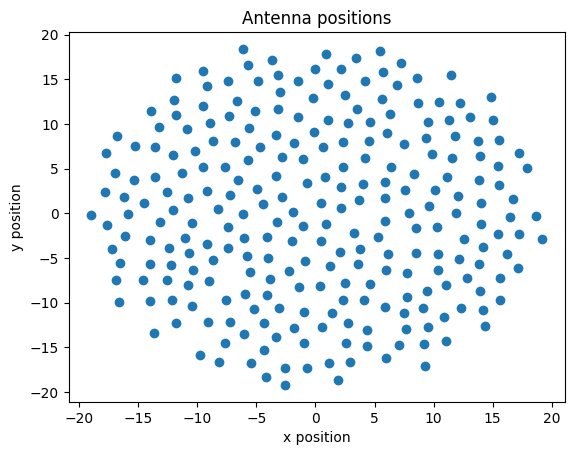

In [198]:
# plor pos_ant in a scatter plot
plt.scatter(x_pos, y_pos)
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Antenna positions')
plt.show()


In [199]:
# these voltage matrices are of size num_theta*num_phi x num_ant
# The EEP of antenna i_ant at position pos_ant(i_ant,:) is in v[:, i_ant]

## Q 3. the model matrix, the covariance matrix, the exact gain values and (my) gain estimations are loaded as
filename_vismat = f"data_20feb2024_2330_100MHz.mat"
mat = scipy.io.loadmat(data_folder + "/" + filename_vismat)
R = np.array(mat['R']) # covariance matrix
M_AEP = np.array(mat['M_AEP']) # model matrix using AEP
M_EEPs = np.array(mat['M_EEPs']) # model matrix using all EEPs
g_sol = np.array(mat['g_sol']) # exact gain solution
g_AEP = np.array(mat['g_AEP']) # estimation using M_AEP (using this for question 5 and 6 only if you haven't been able to complete question 3 and 4)
g_EEPs = np.array(mat['g_EEPs']) # estimation using M_EEPs

In [200]:
# remove the diagonal part of R
R = R - np.diag(np.diag(R))

In [201]:
abs(R)

array([[      0.        , 1586398.29421694,  623110.94417037, ...,
          41391.89191728,    6232.57644968,  120191.72073912],
       [1586398.29421694,       0.        ,  902892.63920566, ...,
          49508.00535737,   17689.29764462,   60506.97647854],
       [ 623110.94417037,  902892.63920566,       0.        , ...,
          64101.24729302,   43331.01678777,   16837.32635073],
       ...,
       [  41391.89191728,   49508.00535737,   64101.24729302, ...,
              0.        ,   20563.24715811,   11757.70953838],
       [   6232.57644968,   17689.29764462,   43331.01678777, ...,
          20563.24715811,       0.        ,    5025.23781277],
       [ 120191.72073912,   60506.97647854,   16837.32635073, ...,
          11757.70953838,    5025.23781277,       0.        ]])

/var/folders/ry/r28_vw1507xg9nf1c8mtsr500000gn/T/ipykernel_805/1064368790.py:3: RuntimeWarning: divide by zero encountered in log
  axs[0].matshow(np.log(np.abs(R)))
/var/folders/ry/r28_vw1507xg9nf1c8mtsr500000gn/T/ipykernel_805/1064368790.py:5: RuntimeWarning: divide by zero encountered in log
  axs[1].matshow(np.log(np.abs(M_AEP)))
/var/folders/ry/r28_vw1507xg9nf1c8mtsr500000gn/T/ipykernel_805/1064368790.py:7: RuntimeWarning: divide by zero encountered in log
  axs[2].matshow(np.log(np.abs(M_EEPs)))
/var/folders/ry/r28_vw1507xg9nf1c8mtsr500000gn/T/ipykernel_805/1064368790.py:12: RuntimeWarning: divide by zero encountered in log
  cbar = ax.figure.colorbar(ax.imshow(np.log(np.abs(R)), cmap='viridis'), ax=ax)


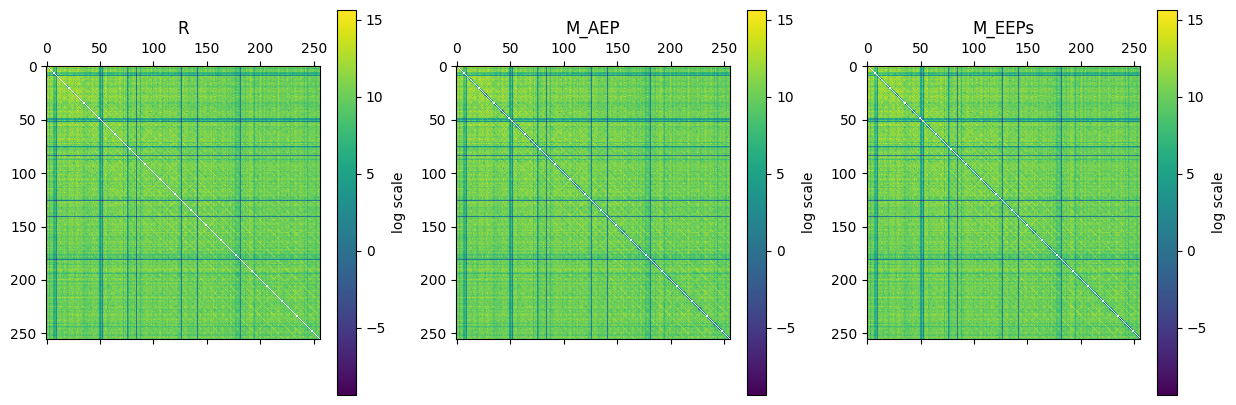

In [202]:
# plot R, M_AEP, M_EEPs matrix in subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].matshow(np.log(np.abs(R)))
axs[0].set_title('R')
axs[1].matshow(np.log(np.abs(M_AEP)))
axs[1].set_title('M_AEP')
axs[2].matshow(np.log(np.abs(M_EEPs)))
axs[2].set_title('M_EEPs')

# set the colorbar
for ax in axs:
    cbar = ax.figure.colorbar(ax.imshow(np.log(np.abs(R)), cmap='viridis'), ax=ax)
    cbar.set_label('log scale')

plt.savefig('figures/R_M_AEP_M_EEPs.png')
plt.show()


/var/folders/ry/r28_vw1507xg9nf1c8mtsr500000gn/T/ipykernel_805/1649419883.py:2: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(np.abs(R - np.diag(g_AEP.flatten()) @ M_AEP @ np.diag(g_AEP.flatten().conj().T))))


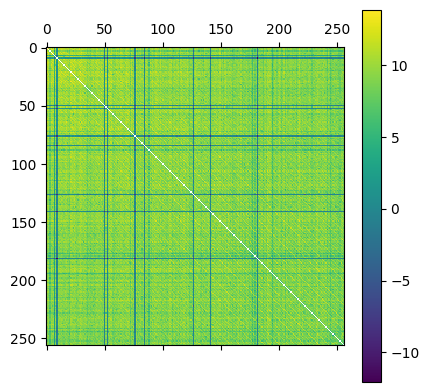

In [203]:
# plot R matrix
plt.matshow(np.log(np.abs(R - np.diag(g_AEP.flatten()) @ M_AEP @ np.diag(g_AEP.flatten().conj().T))))
plt.colorbar()
plt.show()

### 2. Power of EEPs and AEP

In [204]:
phi = np.array([0]*100)[:,None]  
theta = np.linspace(-np.pi/2, np.pi/2, 100)[:,None]  

In [205]:
v_theta_polY, v_phi_polY, v_theta_polX, v_phi_polX = compute_EEPs(theta, phi)

In [206]:
v_polY = np.sqrt(np.abs(v_theta_polY)**2 + np.abs(v_phi_polY)**2)
average_v_polY = np.mean(v_polY, axis=1)

In [207]:
v_polY_db = 20*np.log10(v_polY)
average_v_polY_db = 20*np.log10(average_v_polY)

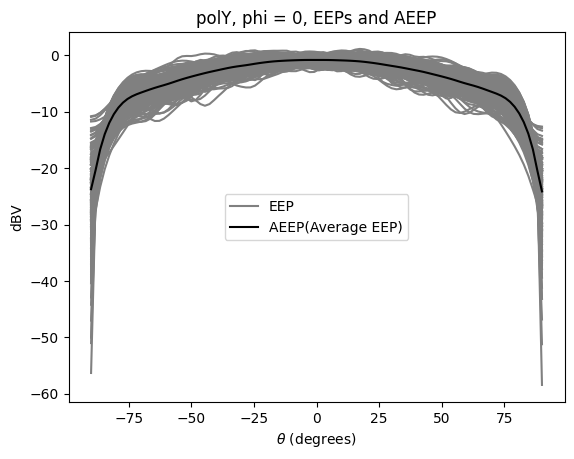

In [208]:
plt.figure()
phi = np.array([0]*100)[:,None]  
theta = np.linspace(-90, 90, 100)[:,None] 
plt.plot(theta, v_polY_db, label='EEP', color = 'grey')
plt.plot(theta, average_v_polY_db, label='AEEP(Average EEP)', color = 'black')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel('dBV')
plt.title(f'polY, phi = {phi[0,0]}, EEPs and AEEP')

# Get handles and labels for unique legend entries
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Create the legend with unique entries
plt.legend(unique_handles, unique_labels, loc='center')

# save the figure in a .png file
plt.savefig(r'figures/EEPs_and_AEP.png')

plt.show()

### 3. StEFCal Algorithm

In [209]:
# define the functions to compute the Frobenius norm of a matrix, or the norm of a vector
def frobenius_norm(A):
    """
    returns the Frobenius norm of a matrix A
    
    args:
    A: np.array of size (n,m)

    returns:
    float: Frobenius norm of A
    """
    if A.shape == (A.shape[0],):
        # if A is a vector, return its norm
        return np.linalg.norm(A)
    return np.linalg.norm(A, 'fro')

In [210]:
class G_solver:
    def __init__(self):
        """
        initializes the G_solver class
        
        args:
        None

        returns:
        None
        """

    def load_values(self, filename = f"harp_beam/data_20feb2024_2330_100MHz.mat"):
        """
        loads R, M, g_sol, g_AEP, g_EEPs from the .mat file
        
        args:
        g_sol: np.array of size (n,)

        returns:
        None
        """
        mat = scipy.io.loadmat(filename)
        self.R = np.array(mat['R']) # covariance matrix
        self.M_AEP = np.array(mat['M_AEP']) # model matrix using AEP
        self.M_EEPs = np.array(mat['M_EEPs']) # model matrix using all EEPs
        self.g_sol = np.array(mat['g_sol']) # exact gain solution
        self.g_AEP = np.array(mat['g_AEP']) # estimation using M_AEP (using this for question 5 and 6 only if you haven't been able to complete question 3 and 4)
        self.g_EEPs = np.array(mat['g_EEPs']) # estimation using M_EEPs
        pass

    def estimate_g(self, R, M, G_init, max_iter = 1000, tau = 1e-6, correction_coeff = 1/2, quiet = False):
        """
        estimates the gain vector g using the model matrix M and the covariance matrix R, using StEFCal

        args:
        G_init: np.array of size (n,)
        iMax: int
        tau: float

        returns:
        None
        """

        R = R.astype(complex)
        M = M.astype(complex)
        g = G_init.astype(complex)
        assert R.shape == M.shape, "R and M must have the same shape"
        assert G_init.shape == (R.shape[0],), "G must be a vector of the same size as the number of antennas"
        self.f_norm = []
        self.g_history = [G_init]
        self.residual = [frobenius_norm(R - np.diag(g) * M * np.diag(g).conj().T)]
        for i in range (max_iter):
            g_cache = g.copy()
            for p in range (256):
                z = g_cache * M[:,p]
                z.astype(complex)
                dot_product = np.dot(R[:,p].conj().T, z)
                dot_product.astype(complex)
                normalisation = np.dot(z.conj().T,z)
                normalisation.astype(complex)
                new_p = dot_product/normalisation
                g[p] = new_p
                g.astype(complex)
            self.g_history.append(g)
            self.f_norm.append(frobenius_norm(g - g_cache)/frobenius_norm(g))
            self.residual.append(frobenius_norm(R - np.diag(g) @ M @ np.diag(g).conj().T))
            if i%2 == 0:
                if frobenius_norm(g - g_cache)/frobenius_norm(g) < tau:
                    # Convergence reached 
                    if not quiet:
                        print ("Convergence reached at iteration ", i)
                        print ("Frobenius norm of the difference between g and g_cache divided by the Frobenius norm of g: ", frobenius_norm(g - g_cache)/frobenius_norm(g))
                    self.convergence_iter = i
                    self.g_est = g
                    break
                else:
                    g = g - correction_coeff * (g-g_cache)
            
        self.g_est = g

    def get_num_of_iter(self):
        """
        returns the number of iterations before convergence
        
        args:
        None

        returns:
        int: number of iterations
        """
        return self.convergence_iter

    def get_g_history(self):
        """
        returns a numpy array of estimated gain vectors
        
        args:
        None

        returns:
        list: list of estimated gain vectors
        """
        return np.array(self.g_history)
    
    def get_f_norm(self):
        """
        returns a numpy array of Frobenius norms
        
        args:
        None

        returns:
        list: list of Frobenius norms
        """
        return np.array(self.f_norm)


    def absolute_error(self):
        """
        returns the absolute error between the estimated gain and the exact gain
        
        args:
        None

        returns:
        list: 
            -[0]: absolute error between the estimated gain and the exact gain
            -[1]: absolute error between the magnitude of estimated gain and the exact gain
            -[2]: absolute error between the angle of estimated gain and the exact gain
        """
        no_iter = len(self.g_history)
        g_sol = self.g_sol
        g_history = self.g_history
        f_norm_history_abs = [np.mean(np.abs(g_history[iter_] - g_sol.flatten())) for iter_ in range(no_iter)]
        f_norm_history_mag = [np.mean(np.abs(np.abs(g_history[iter_])- np.abs(g_sol.flatten()))) for iter_ in range(no_iter)]
        f_norm_history_angle = [np.mean(np.abs(np.angle(g_history[iter_])- np.angle(g_sol.flatten()))) for iter_ in range(no_iter)]
        return f_norm_history_abs, f_norm_history_mag, f_norm_history_angle


In [211]:
# intialize the G_solver class
g_init = np.array([1*np.exp(0.5j)] * 256)
g_init = g_init.astype(complex)

In [212]:
# compute the gain estimation using the AEP model
solver_AEP = G_solver()
solver_AEP.load_values()
solver_AEP.estimate_g(R, M_AEP, g_init, max_iter = 10000, tau =1e-5)


Convergence reached at iteration  230
Frobenius norm of the difference between g and g_cache divided by the Frobenius norm of g:  9.9146005978055e-06


In [213]:

# compute the gain estimation using the EEPs model
solver_EEPs = G_solver()
solver_EEPs.load_values()
solver_EEPs.estimate_g(R, M_EEPs, g_init, max_iter = 10000, tau = 1e-5)

Convergence reached at iteration  192
Frobenius norm of the difference between g and g_cache divided by the Frobenius norm of g:  9.630150195394827e-06


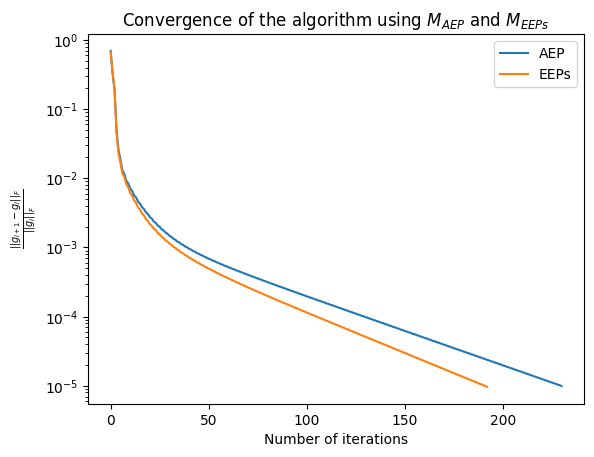

In [214]:
# plot the convergence of the algorithm
plt.plot(solver_AEP.f_norm, label = "AEP")
plt.plot(solver_EEPs.f_norm, label = "EEPs")
plt.yscale('log')
plt.xlabel("Number of iterations")
plt.ylabel(r"$\frac{||g_{i+1} - g_i||_F}{||g_i||_F}$")
plt.legend()
plt.title(r"Convergence of the algorithm using $M_{AEP}$ and $M_{EEPs}$")
plt.savefig('figures/convergence.png')
plt.show()

####  Model Optimisation

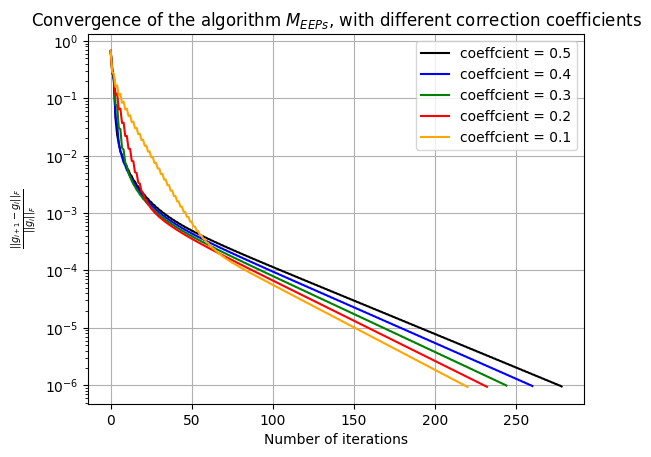

In [215]:
### compare the number of iteration required for each optimisation
# Use EEPs and test taus in [1e-2 to 1e_6]

g_init = np.array([1*np.exp(0.5j)] * 256)

# solver_original = G_solver()
# solver_original.load_values()
# solver_original.estimate_g(R, M_EEPs, g_init, max_iter = 10000, tau = 1e-6)
f_norm = []
coeffs = [0.5, 0.4, 0.3, 0.2, 0.1]
for coeff in coeffs:
    solver_coeff = G_solver()
    solver_coeff.load_values()
    solver_coeff.estimate_g(R, M_EEPs, g_init, max_iter = 10000, tau = 1e-6, correction_coeff = coeff, quiet = True)
    f_norm.append(solver_coeff.f_norm)

# plot the errors, using color form dark to light
c = ['black', 'blue', 'green', 'red', 'orange']
for i in range(len(f_norm)):
    plt.plot(f_norm[i], label = f"coeffcient = {coeffs[i]}", color = c[i])

plt.yscale('log')
plt.xlabel("Number of iterations")
plt.ylabel(r"$\frac{||g_{i+1} - g_i||_F}{||g_i||_F}$")
plt.legend()
plt.grid()
plt.title(r"Convergence of the algorithm $M_{EEPs}$, with different correction coefficients")
plt.savefig('figures/optimisation.png')
plt.show()

### 4. Error Analysis

In [216]:
g_AEP_est = solver_AEP.g_est
g_EEPs_est = solver_EEPs.g_est

residual_AEP = solver_AEP.residual
residual_EEPs = solver_EEPs.residual

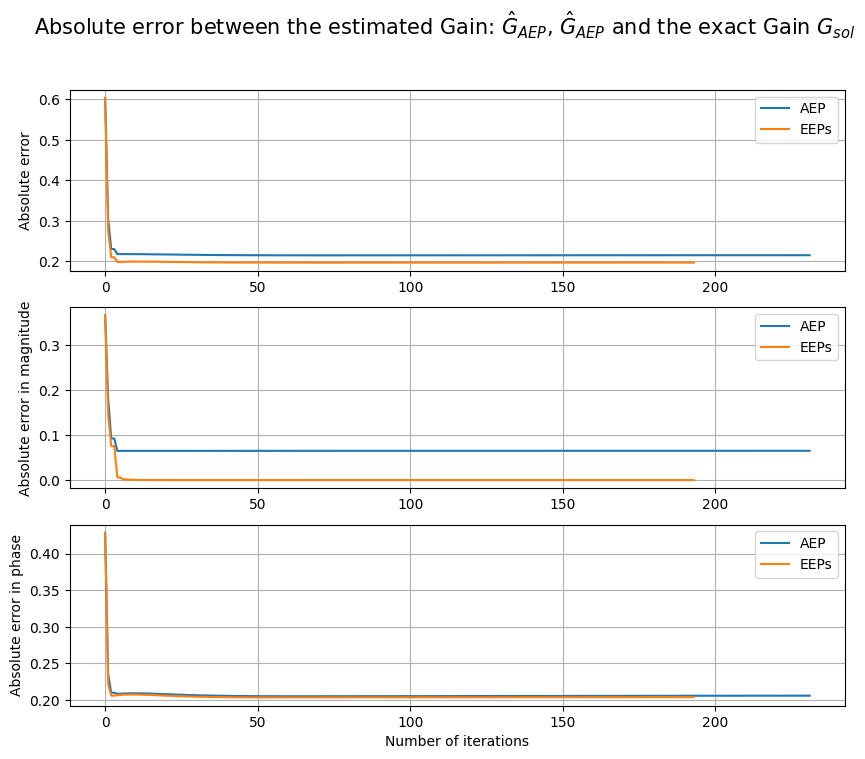

In [217]:
# plot three subplots of the absolute error between the estimated gain and the exact gain
fig, axs = plt.subplots(3,1, figsize=(10,8))

axs[0].plot(solver_AEP.absolute_error()[0], label = "AEP")
axs[0].plot(solver_EEPs.absolute_error()[0], label = "EEPs")
axs[0].set_ylabel('Absolute error')
# axs[0].set_title('Absolute error')

axs[1].plot(solver_AEP.absolute_error()[1], label = "AEP")
axs[1].plot(solver_EEPs.absolute_error()[1], label = "EEPs")
axs[1].set_ylabel('Absolute error in magnitude')
# axs[1].set_title('Absolute error in magnitude')

axs[2].plot(solver_AEP.absolute_error()[2], label = "AEP")
axs[2].plot(solver_EEPs.absolute_error()[2], label = "EEPs")
axs[2].set_ylabel('Absolute error in phase')
axs[2].set_xlabel('Number of iterations')
# axs[2].set_title('Absolute error in phase')

for ax in axs:
    ax.legend()
    ax.grid()

fig.suptitle(r'Absolute error between the estimated Gain: $\hat{G}_{AEP}$, $\hat{G}_{AEP}$ and the exact Gain $G_{sol}$', fontsize=15)
plt.savefig('figures/absolute_error_subplots.png')

plt.show()

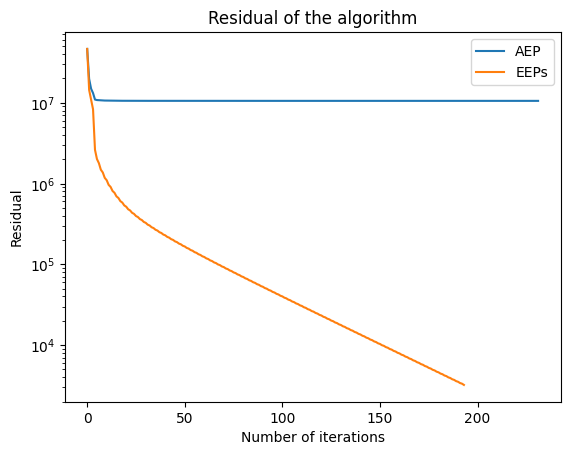

In [218]:
# plot the residual of the algorithm for AEP and EEPs
plt.plot(residual_AEP, label = "AEP")
plt.plot(residual_EEPs, label = "EEPs")
plt.xlabel("Number of iterations")
plt.ylabel("Residual")
plt.yscale('log')
plt.title("Residual of the algorithm")
plt.legend()
plt.show()


### 5. Power of the beamformed voltages with calibrated out the unknown gain $G_i$

In [219]:
freq = 100
c0 = 299792458  # speed of light
k0 = 2 * np.pi * freq / c0 * 10**6 

In [220]:
# sample N points between -pi/2 and pi/2
N = 1000

In [221]:
theta_0 = 0*np.pi/180
phi_0 = 0*np.pi/180
# construct the beamforming weights
x = np.sin(theta_0) * np.cos(phi_0) * x_pos + np.sin(theta_0) * np.sin(phi_0) * y_pos
w = np.exp(1j * k0 * x)
w = w.astype(complex)

In [222]:
theta = np.linspace(-np.pi/2, np.pi/2, N)[:,None]
phi = np.array([0]*N)[:,None]

In [223]:
v_theta_polY, v_phi_polY, v_theta_polX, v_phi_polX = compute_EEPs(theta, phi)

In [224]:
def calibration(v_theta, v_phi, g, w, theta, phi):
    """
    calibrates the EEPs using the estimated gain g
    
    args:
    v_theta_polY: np.array of size (N, 1)
    v_phi_polY: np.array of size (N, 1)
    g: np.array of size (256, 1)
    
    returns:
    np.array of size (N, 1)
    """
    v_theta = v_theta * g
    v_phi = v_phi * g
    phase_factor = np.exp(-1j * k0 * (np.sin(theta) * np.cos(phi) * x_pos + np.sin(theta) * np.sin(phi) * y_pos))
    b_theta = np.sum(v_theta * w * phase_factor, axis = 1)
    b_phi= np.sum(v_phi * w * phase_factor, axis = 1)

    b= np.sqrt(np.abs(b_theta)**2 + np.abs(b_phi)**2) 
    b_db = 20*np.log10(b)

    return b_db

In [225]:
theta = np.linspace(-np.pi/2, np.pi/2, N)[:,None]
phi = np.array([0]*N)[:,None]

b_uncalibrated_db = calibration(v_theta_polY, v_phi_polY, np.ones(256), w, theta, phi)
b_calibrated_db_sol = calibration(v_theta_polY, v_phi_polY, g_sol.flatten(), w, theta, phi)
b_calibrated_db_AEP = calibration(v_theta_polY, v_phi_polY, g_AEP_est, w, theta, phi)
b_calibrated_db_EEPs = calibration(v_theta_polY, v_phi_polY, g_EEPs_est, w, theta, phi)

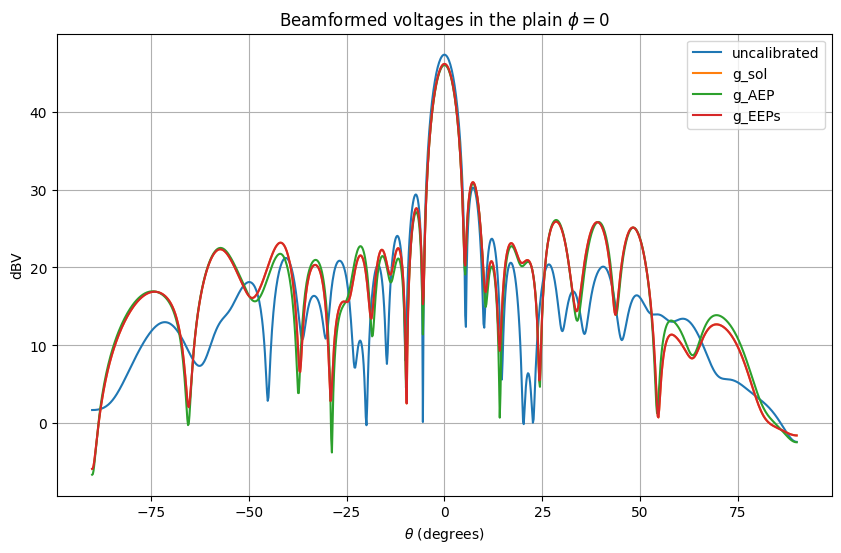

In [234]:
# plot station beam against theta 
# set the size of the figure
plt.figure(figsize=(10, 6))
theta = np.linspace(-90, 90, N)[:,None]
plt.plot(theta, b_uncalibrated_db, label = 'uncalibrated')
plt.plot(theta, b_calibrated_db_sol, label = 'g_sol')
plt.plot(theta, b_calibrated_db_AEP, label = 'g_AEP')
plt.plot(theta, b_calibrated_db_EEPs, label = 'g_EEPs')
# plt.plot(theta, b_polY_calibrated_db, label = 'b_polY_calibrated')
plt.xlabel(r'$\theta$ (degrees)')
plt.ylabel('dBV')
plt.title(r'Beamformed voltages in the plain $\phi = 0$')
plt.legend()
plt.grid()
plt.savefig('figures/beamformed_voltages.png')
plt.show()

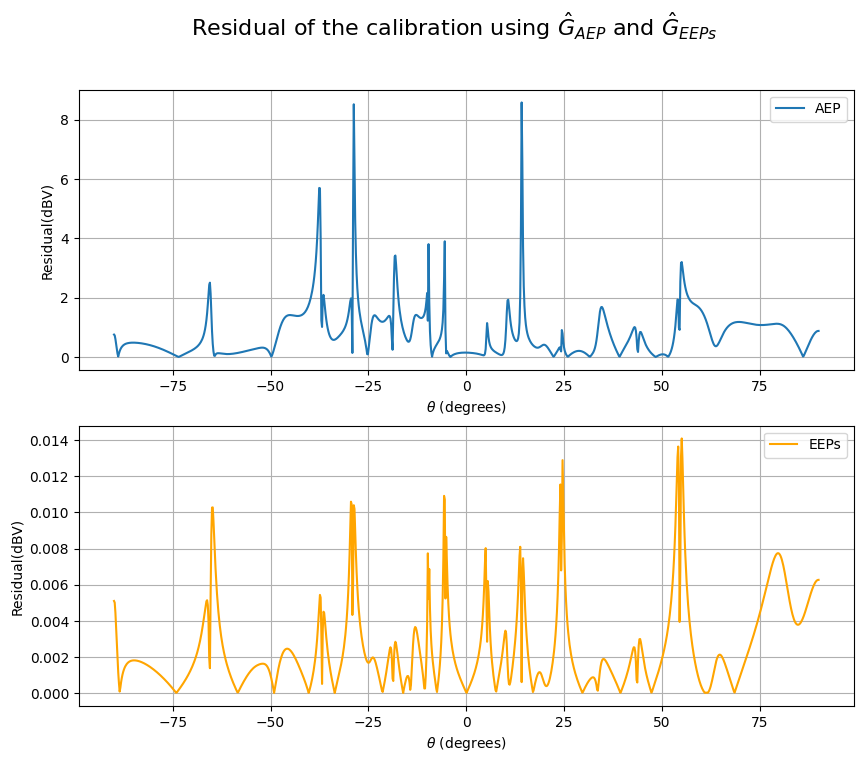

In [227]:
# calculate the error between the calibrated beam and the exact beam
residual_AEP = np.abs(b_calibrated_db_AEP - b_calibrated_db_sol)
residual_EEPs = np.abs(b_calibrated_db_EEPs - b_calibrated_db_sol)

# plot a subplot of the residual of the calibration
fig, axs = plt.subplots(2,1, figsize=(10,8))

axs[0].plot(theta, residual_AEP, label = "AEP")
axs[0].set_ylabel('Residual(dBV)')
# axs[0].set_title('Residual of the calibration')

axs[1].plot(theta, residual_EEPs, label = "EEPs", color = 'orange')
axs[1].set_ylabel('Residual(dBV)')
# axs[1].set_title('Residual of the calibration')

for ax in axs:
    ax.legend()
    ax.set_xlabel(r'$\theta$ (degrees)')
    ax.grid()

fig.suptitle(r'Residual of the calibration using $\hat{G}_{AEP}$ and $\hat{G}_{EEPs}$', fontsize=16)
plt.savefig('figures/beamformed_residual_subplots.png')

plt.show()


### 6. Plot Accurate calibrate solutions

In [360]:
# point at theta = 40, phi = 80
theta_0 = 40*np.pi/180
phi_0 = 80*np.pi/180

In [361]:
# Assume phi and theta are 1D arrays representing the angle from the z-axis and the azimuthal angle, respectively

phi = np.linspace(0, np.pi*2, 360) # From 0 to 360 degrees in radians)
theta = np.linspace(0, np.pi/2 , 90) #From 0 to 90 degrees in radians
mesh_phi, mesh_theta = np.meshgrid(phi, theta)
v_theta_polY, v_phi_polY, v_theta_polX, v_phi_polX = compute_EEPs(mesh_theta.flatten()[:,None],mesh_phi.flatten()[:,None]) # Example function to generate data

In [362]:
# construct the beamforming weights
x = np.sin(theta_0) * np.cos(phi_0) * x_pos + np.sin(theta_0) * np.sin(phi_0) * y_pos
w = np.exp(1j * k0 * x)
w = w.astype(complex)

phi = np.linspace(0, np.pi*2, 360) # From 0 to 360 degrees in radians)
theta = np.linspace(0, np.pi/2 , 90) #From 0 to 90 degrees in radians
mesh_theta, mesh_phi = np.meshgrid(theta, phi)

b_uncalibrated = calibration(v_theta_polY, v_phi_polY, np.ones(256), w, mesh_theta.flatten()[:,None],mesh_phi.flatten()[:,None]).reshape(360, 90)

b_calibrated = calibration(v_theta_polY, v_phi_polY, g_EEPs_est, w, mesh_theta.flatten()[:,None],mesh_phi.flatten()[:,None]).reshape(360, 90)

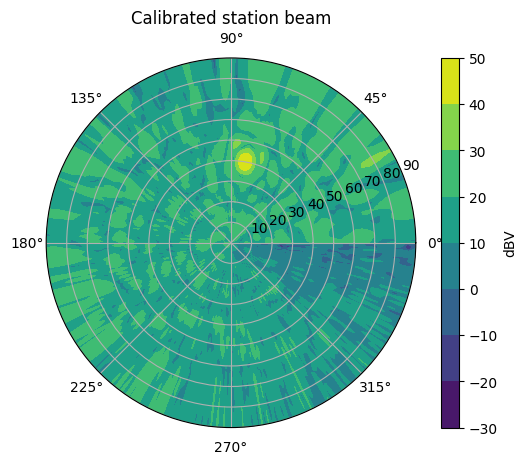

In [363]:
# plot calibrated beam

# mesh_phi and mesh_theta would typically be 2D arrays defining the grid in polar coordinates
phi = np.linspace(0, np.pi*2, 360) 
theta = np.linspace(0, 90, 90)
mesh_theta, mesh_phi = np.meshgrid(theta, phi)  # Meshgrid for phi and theta

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Create the contour plot, interpreting 'phi' as the radial distance
# Use contour for line contours or contourf for filled contours
# CS = ax.pcolormesh(mesh_phi, mesh_theta, b_calibrated)
CS = ax.contourf(mesh_phi, mesh_theta, b_calibrated)

# Add a colorbar for reference
cbar = plt.colorbar(CS, label='dBV')

# Add a title
plt.title('Calibrated station beam')

plt.savefig('figures/calibrated_station_beam.png')
plt.show()

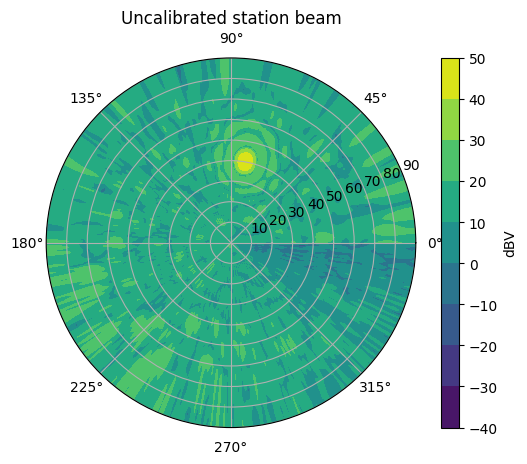

In [364]:
# plot uncalibrated beam
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

# Create the contour plot, interpreting 'phi' as the radial distance
# Use contour for line contours or contourf for filled contours
# CS = ax.pcolormesh(mesh_phi, mesh_theta, b_uncalibrated)
CS = ax.contourf(mesh_phi, mesh_theta, b_uncalibrated)

# Add a colorbar for reference
cbar = plt.colorbar(CS, label='dBV')

plt.title('Uncalibrated station beam')

plt.savefig('figures/uncalibrated_station_beam.png')
plt.show()